In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic, ICRS

In [40]:
sys.path.append('/Users/ratzenboe/Documents/work/code/notebooks/SBI/')
from SBI.modules.ClusterSim import ClusterSim

# Load field stars

In [167]:
fpath_bg = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/edr3_mock_200pc-BG-Sept_29_2022.csv'
df_field = pd.read_csv(fpath_bg)
# Remove sources outside 100 pc from the Sun
df_field_100pc = df_field.loc[df_field['parallax'] > 10].copy()
df_field_100pc['labels'] = -1

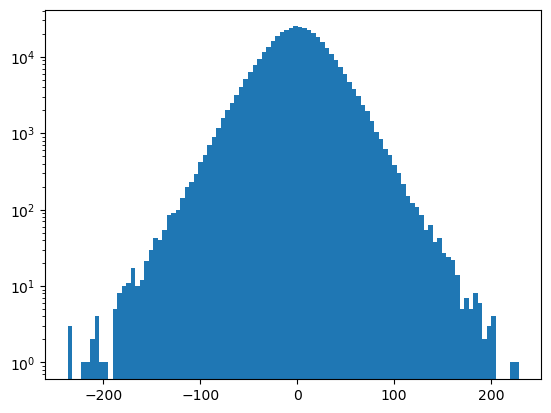

In [168]:
plt.hist(df_field_100pc.radial_velocity, bins=100, log=True);

# Define paths

In [169]:
# ------ Path files ------
fpath = '/Users/ratzenboe/Documents/work/code/notebooks/SBI/'
ir_files = fpath + 'isochrone_files/ir_phot/'
gaia_files = fpath + 'isochrone_files/gaia_phot/'
fname_spline_csv = fpath + 'LogErrVsMagSpline.csv'
fname_astrometric_corr = fpath + 'astrometric_corr.npz'
# ------------------------

In [209]:
cols_observed = [
    'X', 'Y', 'Z',
    'parallax', 
    'pmra', 'pmdec', 'radial_velocity',
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
    'j', 'h', 'k', 'w1', 'w2', 'w3', 'w4',
    'irac1', 'irac2', 'irac3', 'irac4', 'mips1'
]

cols_errs = [
    'parallax_error',
    'pmra_error', 'pmdec_error', 'radial_velocity_error',
    'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
    'j_error', 'h_error', 'k_error', 'w1_error', 'w2_error', 'w3_error',
    'w4_error', 'irac1_error', 'irac2_error', 'irac3_error', 'irac4_error', 'mips1_error',
]

In [44]:
kwargs = dict(
    mu=[50, 10, -10, 20, 20, -10],
    cov=np.eye(6),
    mass=1e3,
    logAge=6.7,
    feh=-0.1,
    A_V=0.5,
    f_bin=0.1,
    parsec_gaia_folder=gaia_files,
    parsec_ir_folder=ir_files,
    spline_csv=fname_spline_csv, 
    astrometric_corr=fname_astrometric_corr,
    errors_outside_range=np.nan,
)

cl_sim = ClusterSim(**kwargs)

PARSEC isochrones read and processed!
PARSEC isochrones read and processed!
Total cluster mass is 995.881 (limit was 1000)
Initializing the scanning law object...
Estimating completeness...


In [47]:
# Sample random 3D vector
def sample_random_3d_vector():
    vec3d = np.random.uniform(-1, 1, 3)
    vec3d /= np.linalg.norm(vec3d)
    len_vec = np.random.uniform(0, 5)
    vec3d *= len_vec
    return vec3d

# Simulate cluster data

In [210]:
cluster_data = []

C = np.eye(6)

i = 0
while i < 20:
    df_subset = df_field_100pc.sample(1)
    x, y, z, u, v, w = df_subset[['X', 'Y', 'Z', 'U', 'V', 'W']].values[0]
    dist = np.sqrt(x**2 + y**2 + z**2)
    if dist < 60:
        u_delta, v_delta, w_delta = sample_random_3d_vector()
        u_cluster = u + u_delta
        v_cluster = v + v_delta
        w_cluster = w + w_delta
        
        # TODO: model the cluster dispersion in velocity and position as a function of age  
        C_cluster = np.copy(C)
        xyz_disp = np.random.uniform(2, 6)
        C_cluster[:3, :3] *= xyz_disp**2
        vel_disp = np.random.uniform(1, 2.5)
        C_cluster[3:, 3:] *= vel_disp**2
        
        linAge = np.random.exponential(150, 1)[0]
        logAge = np.log10(linAge*1e6)
        
        if linAge > 1.01:
            print('logAge:', logAge)
            mass = np.random.uniform(1e1, 1e2)*5
            
            mu_6d = np.array([x, y, z, u_cluster, v_cluster, w_cluster])
            print('mu_6d:', mu_6d)
            df_obs_all = cl_sim.data_observed(
                mu=mu_6d, cov=C_cluster, 
                mass=mass, logAge=logAge, feh=0., 
                A_V=0., f_bin=0.2,
            )
            df_true_all = cl_sim.data_true()
            # Rename columns
            df_cluster = df_obs_all.rename(columns={col: col + '_obs' for col in cols_observed}, inplace=False)
            df_cluster['parallax_true'] = df_true_all['parallax'].values
            # df_cluster['mass'] = df_true_all['mass'].values
            # df_cluster['X_true'] = df_true_all['X'].values
            # df_cluster['Y_true'] = df_true_all['Y'].values
            # df_cluster['Z_true'] = df_true_all['Z'].values
            # df_cluster['logAge'] = logAge
            df_cluster['labels'] = i
            df_cluster['U_bulk'] = u
            df_cluster['V_bulk'] = v
            df_cluster['W_bulk'] = w
            # is_not_nan = df_cluster[input_features].isna().sum(axis=1)==0
            # cluster_data.append(df_cluster.loc[is_not_nan])
            cluster_data.append(df_cluster)
            i += 1

logAge: 7.80029925979231
mu_6d: [-17.31418127  30.35901506   7.17530459  -2.49136483 -19.35036854
   3.71104307]
Total cluster mass is 386.431 (limit was 368.722)
logAge: 8.775219158307241
mu_6d: [-38.35488366   8.63505798 -43.32773163 -43.14925816 -48.32062704
 -12.3274568 ]
Total cluster mass is 96.8581 (limit was 100.721)
logAge: 7.934557931517703
mu_6d: [  2.83730618  14.18813684   6.10912248 -61.31844712 -28.07684493
  -9.39462638]
Total cluster mass is 202.802 (limit was 202.477)
logAge: 8.269589667414001
mu_6d: [ 38.60153936  18.99915898 -38.11479227 -34.85341346 -54.3560662
   3.82742503]
Total cluster mass is 423.467 (limit was 423.47)
logAge: 7.5201418716880974
mu_6d: [ 45.68937267 -22.22960568  -5.43767542 -42.84861365 -18.84669375
  13.79040225]
Total cluster mass is 76.7272 (limit was 80.1048)
logAge: 7.325273340533307
mu_6d: [ 37.56913223  37.57122839 -27.2696162  -18.8808097   -2.97156313
  -8.55081547]
Total cluster mass is 89.7536 (limit was 89.5849)
logAge: 7.65960624

In [211]:
df_clusters_all = pd.concat(cluster_data)
df_clusters_all.columns

Index(['ra', 'dec', 'parallax_obs', 'pmra_obs', 'pmdec_obs',
       'radial_velocity_obs', 'phot_g_mean_mag_obs', 'phot_bp_mean_mag_obs',
       'phot_rp_mean_mag_obs', 'j_obs', 'h_obs', 'k_obs', 'w1_obs', 'w2_obs',
       'w3_obs', 'w4_obs', 'irac1_obs', 'irac2_obs', 'irac3_obs', 'irac4_obs',
       'mips1_obs', 'M_G', 'X_obs', 'Y_obs', 'Z_obs', 'U', 'V', 'W',
       'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error',
       'radial_velocity_error', 'phot_g_mean_mag_error',
       'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error', 'j_error',
       'h_error', 'k_error', 'w1_error', 'w2_error', 'w3_error', 'w4_error',
       'irac1_error', 'irac2_error', 'irac3_error', 'irac4_error',
       'mips1_error', 'parallax_true', 'labels', 'U_bulk', 'V_bulk', 'W_bulk'],
      dtype='object')

In [212]:
np.unique(df_clusters_all.labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([650, 186, 369, 847, 152, 184, 551, 872, 737, 604, 526, 424, 688,
        792, 354, 627, 700, 724, 721, 458]))

In [213]:
cols_important = [
    'ra', 'dec',  'parallax_obs', 'pmra_obs', 'pmdec_obs', 'radial_velocity_obs',
]
df_cl = df_clusters_all.dropna(subset=cols_important)

In [214]:
np.unique(df_cl.labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([195,  45, 128, 209,  48,  60, 169, 193, 239, 157, 166, 140, 248,
        161,  55, 196, 176,  39, 251, 159]))

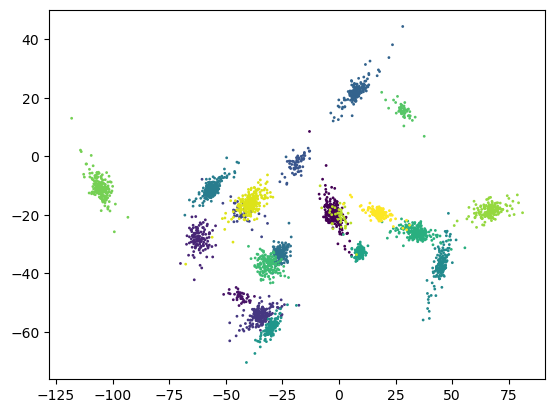

In [215]:
plt.scatter(df_cl.U, df_cl.V, c=df_cl.labels, s=1)

In [216]:
cols_needed = [
    'ra', 'dec', 'parallax_obs', 'pmra_obs', 'pmdec_obs', 'radial_velocity_obs',
    'X_obs', 'Y_obs', 'Z_obs', 'U', 'V', 'W',
    'phot_g_mean_mag_obs', 'phot_bp_mean_mag_obs', 'phot_rp_mean_mag_obs',
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'radial_velocity_error'
]

df_cl[cols_needed]

,ra,dec,parallax_obs,pmra_obs,pmdec_obs,radial_velocity_obs,X_obs,Y_obs,Z_obs,U,...,W,phot_g_mean_mag_obs,phot_bp_mean_mag_obs,phot_rp_mean_mag_obs,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error
413,0.563594,74.294507,26.171245,58.936133,50.073214,-30.033169,-18.453492,32.541637,7.778501,4.552821,...,0.574747,13.915972,15.757865,12.647942,0.014835,0.012980,0.018544,0.019100,0.016504,7.870143
414,18.780431,70.970221,33.624688,84.963826,22.306760,-6.295277,-16.833464,24.148796,4.235666,-5.636125,...,3.302486,13.389158,15.190601,12.110750,0.011911,0.010422,0.014889,0.015335,0.013251,4.787012
416,335.696462,70.299776,30.014997,16.735864,76.538991,-29.537694,-11.700628,30.544030,6.337084,2.716095,...,2.890570,13.611091,15.418022,12.340909,0.012952,0.011333,0.016191,0.016676,0.014410,5.806188
417,356.262264,71.814133,29.338023,54.668943,67.105705,-12.675162,-15.644772,29.743106,5.692746,-3.572746,...,5.966690,13.644654,15.452143,12.359343,0.013195,0.011546,0.016494,0.016989,0.014680,6.056493
418,16.997341,66.455349,26.812243,92.095604,15.200993,-18.426067,-21.128910,30.642998,2.365770,-2.661936,...,2.553459,13.815681,15.630172,12.553754,0.014223,0.012445,0.017778,0.018312,0.015823,7.167623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,227.414045,-53.289881,43.648665,-167.679225,196.468509,27.869835,18.201819,-13.813205,1.663366,17.578651,...,29.570278,NaN,NaN,NaN,0.010355,0.009061,0.012944,0.013332,0.011520,0.811180
452,254.896517,-47.286531,37.458033,-248.906681,70.605971,22.179190,25.020374,-9.206646,-1.387085,17.984153,...,29.113037,NaN,NaN,NaN,0.010355,0.009061,0.012944,0.013332,0.011520,1.004482
453,228.811658,-41.438793,41.048319,-157.067925,130.950761,33.218873,20.465131,-11.872478,5.805772,19.676645,...,29.774871,NaN,NaN,NaN,0.010355,0.009061,0.012944,0.013332,0.011520,1.746810
455,256.211690,-22.588383,56.894413,-397.952541,-4.902030,24.234742,17.244496,0.056576,3.399211,18.689069,...,30.827673,NaN,NaN,NaN,0.010355,0.009061,0.012944,0.013332,0.011520,1.000435


In [240]:
df_cl_final = df_cl[cols_needed + ['labels']].rename(columns={col: col.replace('_obs', '') for col in cols_needed}, inplace=False)
final_labels = [col for col in df_cl_final.columns]

In [241]:
df_field_sample = df_field_100pc[df_cl_final.columns].sample(df_cl_final.shape[0]*20, replace=False)
df_all = pd.concat([df_field_sample, df_cl_final]).reset_index(drop=True)

In [242]:
# df_all.to_csv('/Users/simulated_data.csv', index=False)

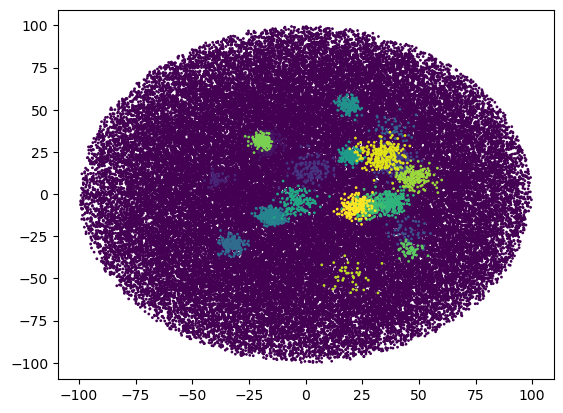

In [269]:
plt.scatter(df_all.X, df_all.Y, c=df_all.labels, s=1)

In [271]:
df_cluster = df_all[['X', 'Y', 'Z', 'pmra', 'pmdec']].copy()

df_cluster[['pmra', 'pmdec']] /= df_all['parallax'] * 10

Index(['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity', 'X', 'Y',
       'Z', 'U', 'V', 'W', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'ra_error', 'dec_error', 'parallax_error',
       'pmra_error', 'pmdec_error', 'radial_velocity_error', 'labels'],
      dtype='object')

In [272]:
# Save data to desktop
df_all.to_csv('/Users/ratzenboe/Desktop/simulated_data.csv', index=False)

In [244]:
features_X = ['X', 'Y', 'Z', 'pmra', 'pmdec']
features_y = ['labels']

In [253]:
# Run a random forest classifier on the data
df_train = df_all[features_X]
df_y = df_all[features_y]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_train, df_y, test_size=0.2, random_state=42)

# clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0).fit(X_train, y_train)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

/Users/ratzenboe/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [254]:
from sklearn.metrics import balanced_accuracy_score, f1_score

In [258]:
np.unique(clf.predict(X_test), return_counts=True)

(array([-1,  0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        18, 19]),
 array([12117,    45,    17,    54,    30,    15,    32,    39,    52,
           37,    33,    31,    56,    32,    12,    40,    19,    57,
           25]))

In [267]:
f1_score(clf.predict(X_test), y_test, ) 

/Users/ratzenboe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.8751085238640989

In [274]:
np.unique(df_all.labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]),
 array([60680,   195,    45,   128,   209,    48,    60,   169,   193,
          239,   157,   166,   140,   248,   161,    55,   196,   176,
           39,   251,   159]))

In [276]:
df_cluster_1 = df_all.loc[df_all.labels == 0]

df_cluster_1.shape

(195, 22)

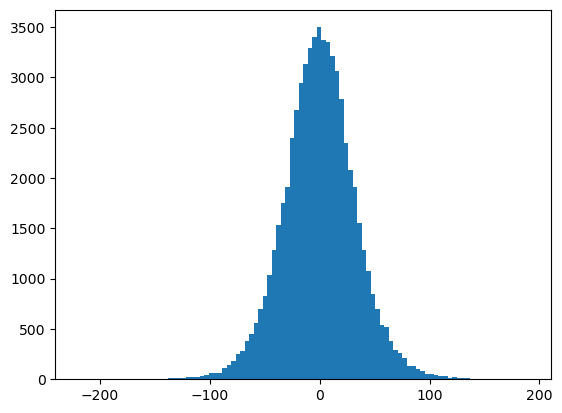

In [278]:
plt.hist(df_all.radial_velocity, bins=100);